# EE 120 Lab 4: Heart Rate Monitoring
v1 - Spring 2019: Dominic Carrano, Sidhant Kaushik, Shubhrakanti Ganguly, Miki Lustig  
v2 - Fall 2019: Dominic Carrano  
v3 - Spring 2020: Anmol Parande, Neha Godbole, Dominic Carrano

In [1]:
from sklearn.decomposition import FastICA
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

You may need to install `sklearn` before the above cell runs. Check out https://scikit-learn.org/stable/install.html for instructions.

# Background

One of the most important vital signs for human beings is their *heart rate*: the number of times their heart beats in a minute. A typical adult human has a resting heart rate in the range of 60-100 beats per minute. People with more active lifestyles tend to have lower average resting heart rates, with competitve atheletes' rates as low as 40 or 50 beats per minute.

Generally, heart rate monitoring is done through high cost devices with a system of sensors designed specifically for that purpose. In this lab, we'll make a heart rate detector with just Python and a cell phone camera by using — you guessed it — the Fourier Transform. And, unlike traditional heart rate monitors, ours will be *contactless*: you only need to hold your thumb near the camera. No direct physical contact with a device is required!

This lab is aimed at giving you a chance to work with some real world data and see how we can analyze its spectrum to create something of practical use. The techniques we'll use in this lab to build our heart-rate monitor are largely based off of the methods published in references 1 and 2.

### Blood Flow and RGB Signals

Your heartbeat drives the flow of blood through your body, which is the key idea we'll use in developing our heart-rate monitor.

Suppose we take a close-up video recording of a person's thumb (other body parts will work too, but it's easiest to just hold your thumb over your cell phone camera). Each image or "frame" of a video contains several pixels, each encoded as a triplet of Red, Green, and Blue (RGB) values. By considering each color channel of the recording as a separate signal — three in total — we get information about the blood flow through that region of their body during the recording. It may seem like the red channel is the only information-bearing signal (since blood is red), but we'll later see that the heartbeat signal is actually mixed in with all three.

# Q1: Data Pre-Processing

The data we use is a video, which is four-dimensional (being a function of time, x-axis pixel, y-axis pixel, and color channel), and we're only familiar with 1D signals. So, to start, let's get our data into a format we know how to work with.

## Reading the data

For this lab, data has been provided for you. It's a 50 second video of a thumb held up close to an iPhone camera, and we'll use it for testing out our algorithms. Using a separate heart rate monitor, we measured the person's heartrate to be 76-82 bpm during the recording.

We've already done some processing for you by converting the video to a numpy array, so that you can avoid dealing with external video processing libraries. Numpy has a very convenient interface for saving and loading numpy arrays, only requiring calls to the functions `np.load` and `np.save`, which operate on an uncompressed `.npy` file format for storing the arrays.

Run the cell below to load the video data as a numpy array. It may take a few seconds.

In [2]:
video_data = np.load("data1.npy")

When dealing with higher dimensional data, `np.info` is a great way to get a summary of the object's attributes. 

We've already seen that `[object]?` displays information about any Numpy object, and, under the hood, the iPython notebook environment is just calling `np.info` on the object. Let's see what we can find out about our video data.

In [3]:
np.info(video_data)

class:  ndarray
shape:  (1520, 200, 260, 3)
strides:  (156000, 780, 3, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x121b57000
byteorder:  little
byteswap:  False
type: uint8


One of the most informative attributes we get back is `shape: (1520, 200, 260, 3)`. 

As discussed above, the video is actually a 4D numpy array, with dimensions corresponding to frames, y pixels, x pixels, and RGB channels, in that order. When numpy tells us the object's shape is the tuple `(1520, 200, 260, 3)`, it's saying that: 
- The video (our array) has of 318 frames, 
- Each frame is a 260x200 grid of pixels (i.e., an image), and 
- Each pixel is composed of 3 values, the R, G, and B components. 

In total, our array should contain $1520 \times 260 \times 200 \times 3 = 237120000$ elements. We can confirm this by asking numpy how many elements are in the `ndarray` by getting its `size` attribute.

In [4]:
video_data.size

237120000

Additionally, we can do a quick sanity check: since the video was taken at 30 frames per second, and we have 1520 frames of data, this corresponds to a 1520 / 30 = ~50 second recording, as expected. Let's watch the video!

In [9]:
HTML("""
    <video alt="test" width="320" height="240" controls>
        <source src="data1.mov" type="video/mp4">
    </video>
""")

If you look closely, you'll see the person's thumb pulsing. The frequency at which this occurs is their heart rate, and we want to extract this information. First, however, we need to find a way to convert our video into a more tame 1D signal that we know how to work with.

## Q1a: Spatial Pooling

We need to turn our 4D signal into a 1D signal, since that's all we know how to deal with. To accomplish this, we'll turn to an old friend: **averaging**.

### Spatial Pooling

To reduce our signal from a 4D one to a 1D one, we'll *spatially pool* (in other words, spatially average) the video:
1. First, we separate the red (R), green (G), and blue (B) components from each frame. This gives us three separate 3D video signals, having eliminated the color channel dimension by considering each channel as a separate signal.
2. Second, for each separate color channel, at each point in time (i.e., each frame), replace the image with its average intensity across all pixels. That is, take an average over the *spatial* coordinates which correspond to image pixels. 

This procedure gives us three signals, $x_R(t), x_G(t)$, and  $x_B(t)$, which are the spatially averaged video for each color channel. Technically, these signals have been sampled and discretized, but they came from a CT source, so we'll think of them as being inherently CT.

Spatial pooling does several things that help us out.
- ***Dimensionality reduction***. 
    - By averaging each color channel's images down to a single number, we convert a 3D signal into a 1D signal. 
    - Not only is this easier to visualize and interpret, it's a lot less data to process, leading to a more efficient implementation of our monitor. This becomes especially important in real-time applications!
- ***Compression***.
    - Our video has a high degree of redundancy --- adjacent pixels have nearly identical colors. We don't need all of this information to get a good heart rate signal. 
    - By reducing each $260 \times 200$ frame to a single number, the number of signal values we have to process drops by several orders of magnitude, making our algorithm much faster.
- ***Noise reduction***. 
    - As we've seen in both lab and lecture, averaging (e.g., via a simple or exponential moving average filter) is a simple but effective noise reduction technique. 
    - Here, we average across *spatial pixels* rather than temporal samples, but it still confers the same benefit of noise reduction. 
    - By averaging, we get a more aggregate view of what the video tells us about the person's heart rate, rather than placing all our trust on what may be a very noisy pixel measurement.

Run the cell below to grab each RGB channel's values. Note how the first 3 dimensions (frame index and spatial coordinates of each frame) are completely copied. To grab each signal, we just select which of the three RGB components to take.

In [5]:
# 3D signals for each RGB component
xr_video = video_data[:, :, :, 0] 
xg_video = video_data[:, :, :, 1]
xb_video = video_data[:, :, :, 2]

### Your Job

Now, we have three 3D signals, and want to spatially average them to obtain 1D versions. Fill in the cell below to do this. 

The function [np.mean](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html) will be useful. **Specifically, you'll want to check out the documentation on the `axis` argument.** Rememeber, we want to average along two dimensions (axes) at once: the y pixel values, and the x pixel values, taking the frame at each point in time for our signals and converting it to a single number.

Your code will take a couple seconds to run because there's a lot of data to process. This is why having efficient signal processing algorithms like the FFT or the host of other operations in numpy is so important!

In [6]:
# TODO your averaging code here
xr = np.mean(xr_video, axis=(1, 2))
xg = np.mean(xg_video, axis=(1, 2))
xb = np.mean(xb_video, axis=(1, 2))

Now, in the cell below we'll plot all three channels' averaged signals, $x_R(t), x_G(t), x_B(t)$, on the **same** 16x4 figure. We'll make $x_R(t)$ red, $x_G(t)$ green, and $x_B(t)$ blue so the visualization is easier.

We've provided the plotting code for you. If your averaging was done correctly, your plot should look something like this:

<img src="./unnormalized_spatialavgs.png" alt="drawing" style="width:800px; height=1200px"/>

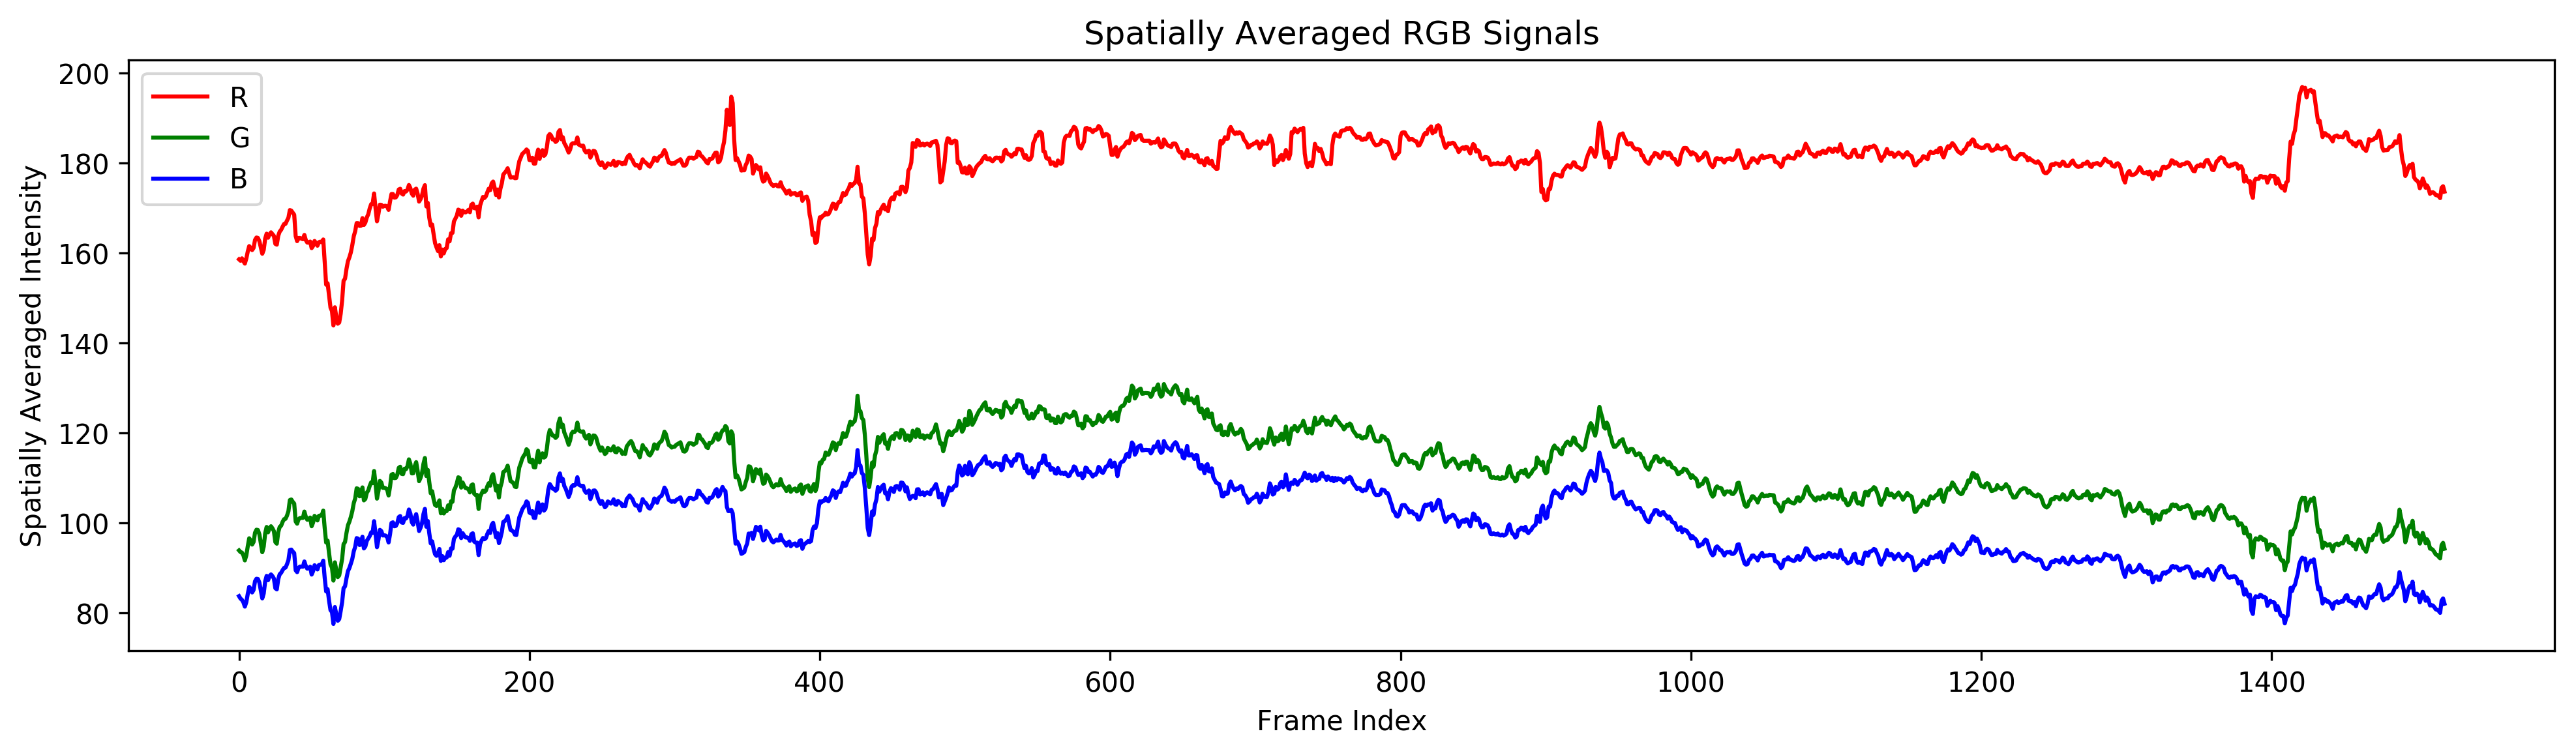

In [7]:
fig = plt.figure(figsize=(16, 4), dpi=300)
plt.plot(xr, color="r", label="R")
plt.plot(xg, color="g", label="G")
plt.plot(xb, color="b", label="B")
plt.legend()
plt.xlabel("Frame Index")
plt.ylabel("Spatially Averaged Intensity")
plt.title("Spatially Averaged RGB Signals")
plt.show()

<hr>  

**Q**: Ignoring vertical offsets (we'll deal with those in the next part), does any one particular channel's signal stick out, do they all have roughly the same shape? Based on this, do you think we should use all three going forward, or just one? 

<span style="color:blue">**A**: (TODO) All channels appear to give us information about a person's heart rate. There is siginficant fluctuation in all of them, and they all look fairly similar. We should make use of all of them.</span>

<hr> 

**Q**: Do you notice anything interesting about the signal that might tell you we might be able to to get a good heart rate measurement?

<span style="color:blue"> **A**: (TODO) There appear to be perioidic bumps in the data. This could indicate the heart rate.</span>
<hr>

## Q1b: Statistical Normalization

As is, your plot from the previous part may be a bit confusing. Why does G look like B, just offset by a few intensity levels? And why is R so much stronger than the other two? The issue is that our signals aren't *normalized*: we're not comparing them on the same scales.

Our skin, up close, is mostly shades of red, so naturally the R component dominates the others. It seems natural to conclude, then, that the red signal must correspond to the movement of blood through our veins, so we should just throw out the others and use $x_R(t)$. However, as you can probably tell from the previous plots, we'd be losing a lot of valuable information in the other two channels by doing that. Also, the authors in [2] showed that such a simple model (where we only use the red channel) is not very robust. 

Later, we'll think of each of these three RGB signals as being a *mixture* (i.e., linear combination) of the true heart-rate signal with some noise sources, and so our job will be to do the un-mixing. It'll make our job much easier, then, to put them on the same scale for comparison first. Think of it this way - which bowl's ingredients would you rather try to separate: one created by mixing equal parts baking soda, sugar, and flour, or one obtained from 90% baking soda, 9% sugar, and 1% flour? 

### Your Job

When we say that the signals aren't normalized, we're speaking in a statistical sense (rather than a vector norm sense): they have different means and variances. We want these to be standard so that we can think of the signals as being akin to random vectors.

In the cell below, statistically normalize the signals by making them have a mean of zero and variance of 1. 

To make a signal $x(t)$ zero mean and unit variance, you can first subtract its mean ($\mu_x$), then divide by its standard deviation ($\sigma_x$), each of which is taken across all samples to return a real number:

$$x_\text{normalized}(t) = \dfrac{x(t) - \mu_x}{\sigma_x}$$

**Hint:** Check out the functions [`np.mean`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html) and [`np.std`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html).

In [8]:
# TODO your normalization code here
xr_normalized = (xr - np.mean(xr)) / np.std(xr)
xg_normalized = (xg - np.mean(xg)) / np.std(xg)
xb_normalized = (xb - np.mean(xb)) / np.std(xb)

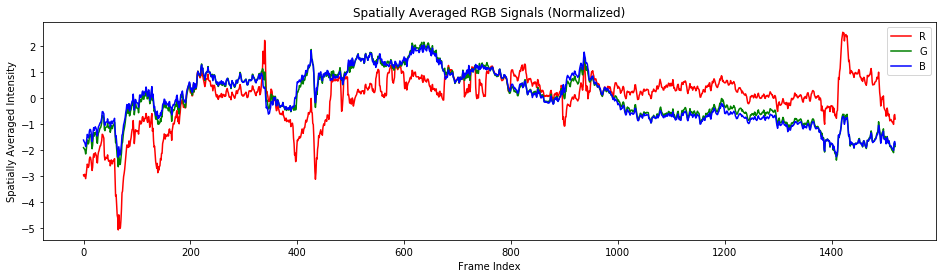

In [9]:
plt.figure(figsize=(16, 4))
plt.plot(xr_normalized, color="r", label="R")
plt.plot(xg_normalized, color="g", label="G")
plt.plot(xb_normalized, color="b", label="B")
plt.legend()
plt.xlabel("Frame Index")
plt.ylabel("Spatially Averaged Intensity")
plt.title("Spatially Averaged RGB Signals (Normalized)")
plt.show()

Compare your normalized plots to the unnormalized plots.

<hr>  

**Q**: Which channels appear to give us the most information about a person's heart rate? Is your answer different from the unnormalized data?

<span style="color:blue">**A**: All channels appear to give the same information (they all have the same quasi-periodic structure), just like in the unnormalized case.</span>

<hr>  

**Q**: Is there anything interesting about the signal that might tell you we might be able to to get a good heart rate measurement? Is your answer different from the unnormalized data? (Hint: It shouldn't be.)

<span style="color:blue">**A**: The quasi-periodic structure is still there.</span>

<hr>  

## Q1c: Blind Source Separation

Before we try to extract heart rate information from our signals, there's one more thing we need to do: unmix.

All the research on non-contact heart rate monitoring says that rather than use the raw RGB signals, we should instead model these signals as being mixtures of some unknown *source signals*, and try to determine these sources. In fact, even contact-based heart rate monitors, such as standard electrocardiograms, use variants of this idea.

### Modelling Signal Mixtures

Unmixing our signals -- a problem known as *Blind Source Separation (BSS)* -- seems (and is) pretty difficult, because
1. We don't know the mapping between source signals and RGB signals,
2. We don't know what the source signals should be interpreted as (we're "blind" to what they are), and
3. We don't know the number of source signals.

To combat the fact that this problem, as stated, seems intractable, we'll make a few simplifying assumptions.

### Assumption: Linearity

In engineering, it's often the case that we want to model the relationship between an input and output, but have limited information. However, there's a standard solution: assume a **linear** model. That is, the mapping that converts our source signals to RGB signals is linear. Is this true? Maybe, maybe not. But, it does give us a path forward and can be thought of as a first-order approximation of the truth.

More formally, this means our 3D signal is a linear combination of the components of a multi-dimensinal source $\vec{s}(t)$, so we can write the mapping as a matrix-vector multiplication:

$$
    \vec{x}(t) = \left[\begin{array}{c}
        x_R(t)\\ x_G(t)\\ x_B(t)
    \end{array}\right] = A\vec{s}(t).
$$

Our job is to find some demixing matrix $W$ such that $\vec{s}(t) \approx W\vec{x}(t).$ 

You might be thinking: "Why don't we just let $W=A^{-1}$, or, if $A$ isn't invertible, let $W$ be the pseudoinverse of $A$?" This is a good question. Indeed, this approach would work if we knew $A$, but we don't know $A$; we have to estimate it.

### Assumption: # of Sources = # of Channels

We've just assumed a linear model for our RGB channels in terms of the source signals. That is,

$$\vec{x}(t) = A\vec{s}(t).$$

Since $\vec{x}(t) \in \mathbb{R}^3$ (with components $x_R(t), x_G(t), x_B(t)$), we know $A \in \mathbb{R}^{3 \times S}$, where $S$ is the number of source signals. We still have complete freedom on choosing $S$, though.

**We'll assume $S = 3$, the number of measured signals.** Again, this feels like it's coming out of nowhere, but it *does* make our problem simpler, which we could certainly use right now. To understand why, let's go back to the behavior of systems of linear equations.
- **If $S > 3$:**
    - We have ***less*** measurements than linear equations to solve. 
    - The system of equations is *underdetermined*.
    - Chances are, there will be infinitely many solutions; there's not enough information to get a unique answer.
- **If $S < 3$:**
    - We have ***more*** measurements than linear equations to solve.
    - The system of equations is *overdetermined*. 
    - Chances are, there's no exact solution; the problem is overconstrained. 
- **If $S = 3$:**
    - We have exactly as many measurements as linear equations to solve. 
    - Chances are, there's a single, unique solution.

#### Why Not Least Squares?

In EECS 16A, you saw that we can use least squares regression to solve overdetermined systems (and, when augmented with the *minimum norm* criterion, can also be used to solve underdetermined systems). Why not try it here? Do we really need to make $S=3$?

In least squares, we have an optimization problem of the form

$$\text{minimize}_\vec{s}\ ||A\vec{s} - \vec{x}||_2^2,$$

where $\vec{s}$ are the source signals, $A$ is the mixing matrix, and $\vec{x}$ contains our RGB signals. In the above optimization problem, we're only minimizing over $\vec{s}$, and we assume knowledge of $A, \vec{x}$. But this doesn't match our setup: we don't know $A$! What we really want is something like 

$$\text{minimize}_{A, \vec{s}}\ ||A\vec{s} - \vec{x}||_2^2,$$

which is *much* harder to solve (formally, it's a *non-convex* optimization problem). This why blind source separation is so difficult: we don't know the sources *or* the weights of the mapping!

### Independent Component Analysis (ICA)

Fortunately, there's a way to solve this unmixing problem: *Independent Component Analysis (ICA)*. It's a topic well outside the scope of EE 120 (some of the relevant details are in EECS 126, 127, and 229A), so we're going to think of it as a black box that magically does the unmixing for us.

The diagram below, taken from the second reference (where videos of faces, rather than thumbs, were used), is the best way to think of what ICA does: ICA takes in the RGB signals, and gives us back its best guess of what the sources were, assuming the linear model we just discussed.

<br><br>
<img src="ICAvisual.png" alt="Drawing" style="width: 50em;"/>

### Your Job

Check out the documentation for [sklearn's implementation of ICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html), and use it to perform BSS on your normalized signals. We already imported `FastICA` earlier. **Store the result in a matrix called `sources`**.

**Hint:** The function will expect your signals input as a single *data matrix*, where each column is a separate signal. First, construct this matrix to pass into the function. A good sanity check is that `np.shape()` of your input matrix is `(1520, 3)` since we have 1520 frames (or, after our 1D-ificiation of the videos, 1520 signal values) and 3 signals.

In [10]:
# TODO create data matrix
normalized = np.vstack([xr_normalized, xg_normalized, xb_normalized])
normalized = normalized.T

In [11]:
# TODO your ICA code here
ica = FastICA()
sources = ica.fit_transform(normalized)

Once done, run the plotting code below to see the extracted sources! 

If your ICA code is correct, your results may look like this:

<img src="./source_sigs1.png" alt="drawing" style="width:800px; height=1200px"/>

**However, ICA is implemented under the hood using a randomized algorithm that can converge to different results each time you run it**, so you may also get something that looks like this:

<img src="./source_sigs2.png" alt="drawing" style="width:800px; height=1200px"/>

Or even like this:

<img src="./source_sigs3.png" alt="drawing" style="width:800px; height=1200px">

Fortunately, the differences won't really affect our ability to correctly extract the heart rate. If you're really concerned, re-run your ICA code a few times until you get something that looks like either of these three plots. Which color's which doesn't matter.

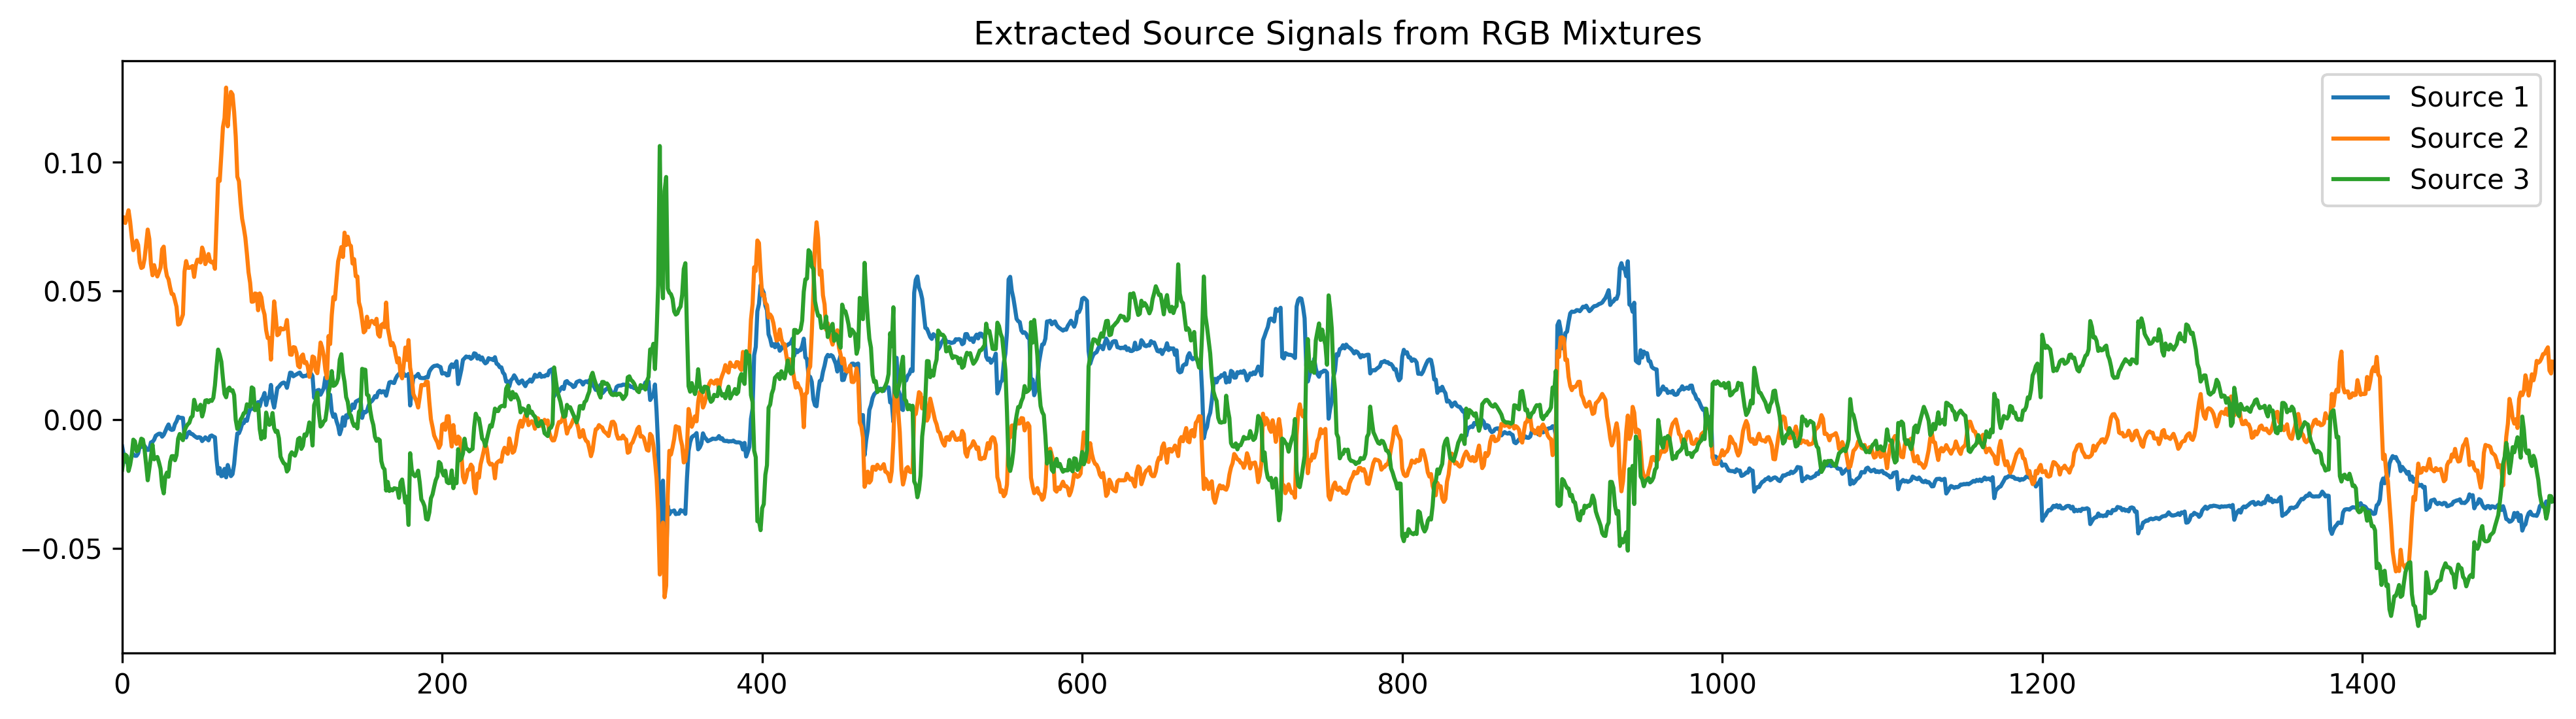

In [12]:
fig = plt.figure(figsize=(16, 4), dpi=300)
plt.plot(sources[:, 0], label="Source 1")
plt.plot(sources[:, 1], label="Source 2")
plt.plot(sources[:, 2], label="Source 3")
plt.legend(loc="upper right")
plt.title("Extracted Source Signals from RGB Mixtures")
plt.xlim([0, len(sources[:, 0])])
plt.show()

# Q2: Power Spectrum Analysis

Believe it or not, we're almost done building our heart rate monitor! Most of the work was turning our raw video into a set of information-bearing signals. Now, we just need to extract a heart rate measurement from them.

## The Power Spectrum of a Signal

The source signals we extracted in Q1c don't look promising as displayed. Instead, we want to look at their Fourier Transforms, since the constituent frequencies in our signals have a natural interpretations here: fluctuations up and down correspond to the person's heart beating. So, the signal's *dominant frequency*, where the magnitude of the DTFT is maximized, should tell us how fast their heart is beating! We want to consider magnitude, not phase, since we care about how "strong" the frequency is, not how it's temporally aligned.

We'll use this idea of finding the dominant frequency to compute the person's estimated heart rate. More specifically, we want the *power spectra* of the signals: **if a DT signal $x(n)$ has DTFT $X(\omega)$, the power spectrum of $x(n)$ is defined as $|X(\omega)|^2$.** 

We could also use the magnitude response $|X(\omega)|$, without any squaring, and still get the same results (since squaring something doesn't affect where its maxima are) but then the spectral peaks (i.e. the local maxima of $|X(\omega)|$) aren't as easy to visually resolve, and it's often useful to visualize things, *especially* when debugging.

## Q2a: Computing the Power Spectrum

In the cell below, compute the power spectrum of each of the three source signals. Store the result in a matrix called `PS`.

**Hint 1:** You should do this all in one line on the ICA-returned data matrix `sources` by using the `axis` parameter of `np.fft.fft`. As for the absolute value and squaring, remember, numpy is built for vectorization - if you call a scalar function (one that maps a number to a number) on a numpy array of any number of dimensions (here, 2, since we have a matrix), numpy will apply it elementwise for you.

**Hint 2:** We adopted the convention above of each column of our data matrix being a separate signal - keep this in mind when figuring out what to pass in for `axis`. A great way to check if you've done this correctly is that `np.shape(PS)` should be the same as `np.shape(sources)`.

In [13]:
# TODO your power spectrum code here
PS = np.abs(np.fft.fft(sources, axis=0)) ** 2

Now, let's plot the signals' power spectra. 

We've provided the plotting code for you, although there's one thing worth commenting on, which is the horizontal axis limits we're using. Realistically, a person's heart rate won't be below 45 bpm (.75 Hz) or above 240 bpm (4 Hz), so it doesn't make sense to look at any frequencies outside of this range; they're just noise. Often, knowledge about the system or task at hand itself, called *meta-information*, helps inform engineers when designing algorithms, and that's exactly the case here. 

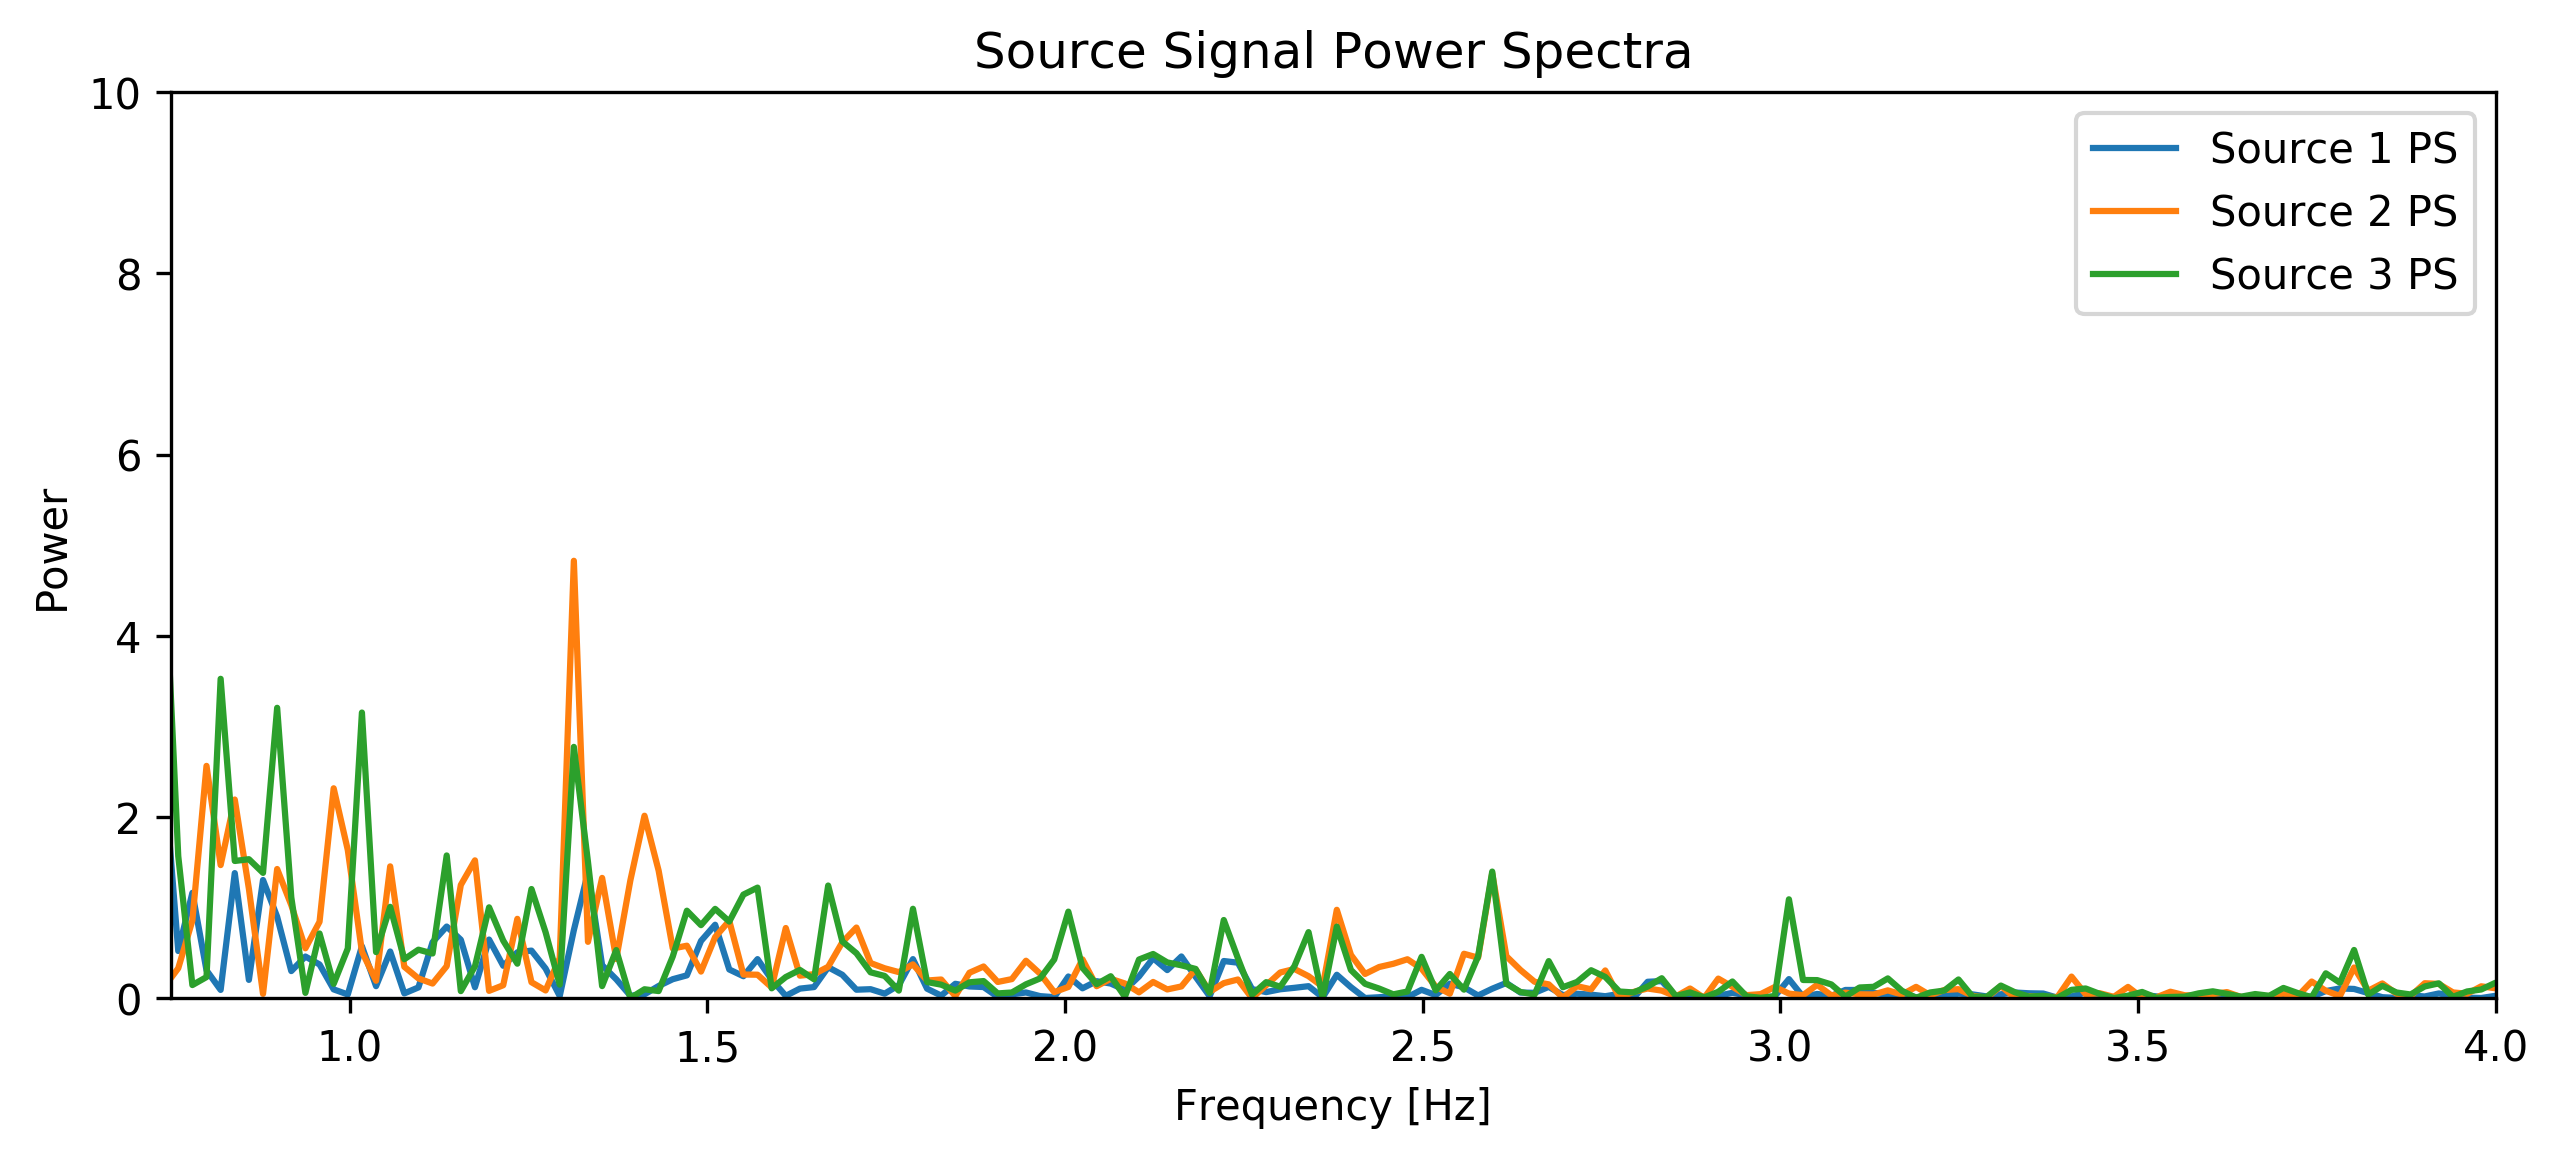

In [14]:
# Plot power spectra
PS_shifted = np.fft.fftshift(PS, axes=0) # shift to -pi to pi
frame_rate = 30
freqs = np.linspace(-frame_rate / 2, frame_rate / 2, len(PS)) # +/- 15 Hz range due to Nyquist rate for 30 fps video

plt.figure(figsize=(10, 4), dpi=300)
plt.plot(freqs, PS_shifted[:, 0], label="Source 1 PS")
plt.plot(freqs, PS_shifted[:, 1], label="Source 2 PS")
plt.plot(freqs, PS_shifted[:, 2], label="Source 3 PS")
plt.title("Source Signal Power Spectra")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.legend(loc="upper right")
plt.xlim([.75, 4]) # Limit viewing range to realistic frequencies
plt.ylim([0, 10])
plt.show()

One of the sources will be considerably stronger than the other two. If your power spectrum code is correct, you should see a large peak around 1.3 Hz and several smaller peaks near 0.8 Hz, 1.0 Hz, 1.45 Hz, and 2.55 Hz.

In order to make our lives easier in the next part, we can collapse the three power spectra down into one by only keeping the largest value at each point in frequency. Intuitively, the largest peaks should correspond to information about the heart beat, so we only care about the largest one detected at each point in time.

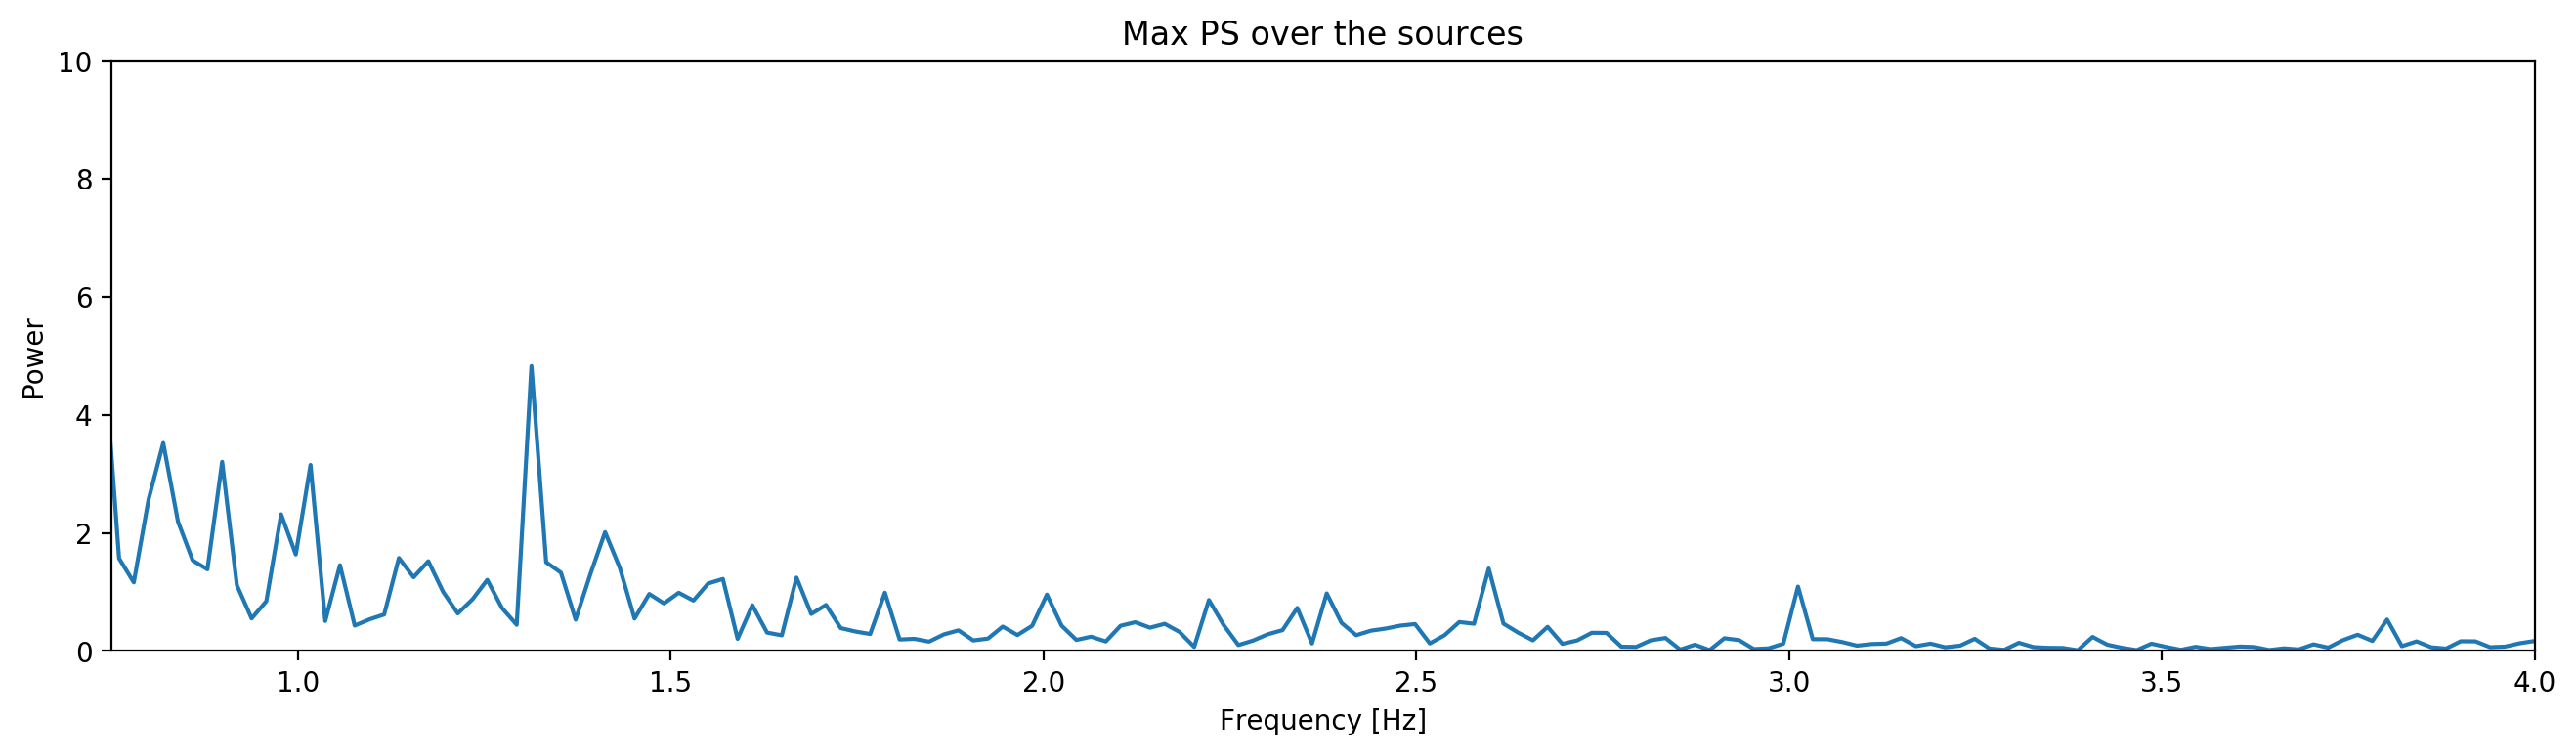

In [15]:
max_ps = np.max(PS_shifted, axis=1)

plt.figure(figsize=(16, 4), dpi=200)
plt.plot(freqs, max_ps)
plt.xlim([.75, 4])
plt.ylim([0, 10])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.title("Max PS over the sources")
plt.show()

From here on, we'll only deal with `max_ps` rather than the 3 separate power spectra.

## Q2b: Extracting the Dominant Frequency

That strongest peak, which occurs at the dominant frequency, is from the person's heart beat! We just need to write some code to extract that frequency, multiply it by 60 (since we want beats per minute, not beats per second), and we'll have computed the person's heart rate! First, let's define some useful constants.

In [16]:
SEC_PER_MIN = 60
MIN_BPM = 45
MAX_BPM = 240

Now, in the cell below, extract the dominant frequency $f_{d}$, and then compute the heart rate from it by:
- Computing the indices of `freqs` (which was defined for you above) that are between 60 bpm and 240 bpm. Check out [np.where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) and [np.bitwise_and](https://docs.scipy.org/doc/numpy/reference/generated/numpy.bitwise_and.html) for doing this.
- Cropping both `freqs` and `max_ps` to this range.
- Extracting $f_{d}$ from the cropped frequencies as the element at the index where your cropped power spectrum is maximized. Check out [np.argmax](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) for this.
- Computing the heart rate from $f_d$ by scaling it by `SEC_PER_MIN`. **Store it in a variable called `hr`.**

In [17]:
# TODO your code here!
max_ps = np.max(PS_shifted, axis=1)
valid_idx = np.where(np.bitwise_and(freqs >= MIN_BPM / SEC_PER_MIN, freqs <= MAX_BPM / SEC_PER_MIN))
valid_ps = max_ps[valid_idx]
valid_freqs = freqs[valid_idx]
hr = valid_freqs[np.argmax(valid_ps)] * SEC_PER_MIN

Once done with the above, run the cell below to see what heart rate you end up getting. For reference, the person's actual heart rate was measured by an independent monitor to vary between 76-82 bpm. See how your result compares!

In [18]:
print("Heart Rate: {0} bpm".format(round(hr, 1)))

Heart Rate: 78.8 bpm


# Q3: Vectorization and Testing on More Data

Now that we've done all the work of implementing the heart rate detection algorithm, let's test it on some real data! We took several videos and converted them to `.npy` files for you; run the next cell to load them. The first is the same one we used throughout Q1 and Q2 above. 

This cell will take a while to run: the `.npy` files are uncompressed, and range from 500 MB to upward of 3 GB in size.

In [19]:
data1 = np.load("data1.npy")
data2 = np.load("data2.npy")
data3 = np.load("data3.npy")

We want to build a single function which we can call with any video to extract the heart rate. We want this function to be fast so we can potentially use it for real-time signal processing. In order to do that, we need to be able to take advantage of numpy's vectorization capabilities.

Fill in the function using your code from above, but vectorize the spatial pooling and data normalization steps.

*Hint:* Focus on the axis argument of numpy functions like `np.mean` and `np.std`. The tuple you pass as axis argument corresponds to the dimension you want to apply the averaging to. For example, in our 4D video, the x and y points are the 1st and 2nd axes.

In [20]:
def meas_hr(raw_data, min_bpm=45, max_bpm=240, frame_rate=30):
    """
    Given a video recording of a person's thumb (raw_data), returns their average heart rate
    for the duration of the recording.
    """
    SEC_PER_MIN = 60
    
    # TODO -> Vectorized Spatial Pooling
    pooled = np.mean(raw_data, axis=(1, 2))
        
    # TODO -> Vectorized Normalization
    normalized = (pooled - np.mean(pooled, axis=0)) / np.std(pooled, axis=0)
        
    # TODO -> ICA to get sources matrix (Copy it from Q1c)
    ica = FastICA()
    sources = ica.fit_transform(normalized)
        
    # TODO -> Compute power spectra (Copy it from Q2a)
    PS = np.abs(np.fft.fftshift(np.fft.fft(sources, axis=0), axes=0)) ** 2
    
    # TODO -> Extracting dominant frequency and convert to heart rate (Copy it from Q2b)
    freqs = np.linspace(-frame_rate / 2, frame_rate / 2, len(PS))
    max_ps = np.max(PS, axis=1)
    valid_idx = np.where((freqs >= min_bpm / SEC_PER_MIN) & (freqs <= max_bpm / SEC_PER_MIN))
    valid_ps = max_ps[valid_idx]
    valid_freqs = freqs[valid_idx]
    hr = valid_freqs[np.argmax(valid_ps)] * SEC_PER_MIN
    return hr

Once done, run the cells below to try out your heart rate monitor! For reference, here are the true heart rates the people had in each dataset.
- Dataset 1: 76-82 bpm. (walking)
- Dataset 2: 66-71 bpm. (resting)
- Dataset 3: 100-105 bpm. (jogging)

Don't worry if you get incorrect results on a few of these - this happens when dealing with real world data! You saw in Q2a that it's possible for multiple peaks to appear. We found that when the algorithm does give an incorrect result, it's typically not because the peak corresponding to the heart rate doesn't exist, but rather that there's some other peak (likely caused by a combination of noise sources) that's stronger. By far the biggest source of errors (once your code is working) will be noisy data - holding your thumb up to a cell phone camera doesn't exactly produce the highest quality recording. Feel free to play with the lower and upper thresholds (`min_bpm` and `max_bpm`) and seeing how your results change as you eliminate more possibilities! 

From a grading perspective, we only care that you're able to synthesize the previous parts we built up into one function and vectorize where appropriate. Everything below here is for you to play around with.

In [21]:
def disp_hr(hr, dataset):
    print("Average Heart Rate (dataset {0}): {1} bpm".format(dataset, round(hr, 1)))

In [22]:
disp_hr(meas_hr(data1), 1)
disp_hr(meas_hr(data2), 2)
disp_hr(meas_hr(data3), 3)

Average Heart Rate (dataset 1): 78.8 bpm
Average Heart Rate (dataset 2): 48.8 bpm
Average Heart Rate (dataset 3): 99.4 bpm
Average Heart Rate (dataset 4): 61.0 bpm


In [23]:
# What if we put the lower limit at 50 for the 2nd dataset? Will the result be made correct?
disp_hr(meas_hr(data2, min_bpm=50), 2)

Average Heart Rate (dataset 2): 69.6 bpm


# (Optional) Using Your Own Video to Determine HR

After using our data to determine heart rate, feel free to take your own video to determine your heart rate. 

For this part, you will need to install [sk-video](https://pypi.org/project/sk-video/) and [FFmpeg](https://www.ffmpeg.org/download.html).

First, take a video holding your thumb over your camera for 10-30 seconds. Using a shorter video is recommended, as the .npy files can get very large. The following code will convert your .mov file to a .npy file and then run your meas_hr code to determine your heart rate. 

In [ ]:
import skvideo.io  

# Fill in "nameofvideo" with the name of your .mov file
my_video = "nameofvideo.mov"
my_data = skvideo.io.vread(my_video)
disp_hr(meas_hr(my_data), 5)

# Further Improvements

We managed to take an approach developed by other researchers, implement it ourselves, and get some pretty cool results! While we did indeed follow the *method* described in [1, 2] for heart rate monitoring (aside from how we acquired our data), there are a few things that could be improved about our specific *implementation* of it.

The main improvement we could make is considering **temporal resolution.** Our monitor computes an average heart rate based on the data we feed it. A common task of interest for professional sports teams is to monitor their players' heart rates during various exercises. Since we only compute a single average, we lose all information about how the heart rate changes with time (if the person's heart rate is constant, we don't lose anything, but there are plenty of scenarios where this won't be the case). To combat this, we could slide a moving window over our data, computing the heart rate over a 30 second window, then advance by 1 second, recompute, and so on, so we get a new estimate for every second. This was what the authors ended up doing in [2].

We encourage you to try these out on your own, in addition to taking data of your own thumb (or even other sources, like other fingers or your cheeks), although you're not required to implement any of them here. In [1,2] the authors used peoples' faces and applied computer vision techniques to select a *Region of Interest* (ROI) to use for heart rate detection; these techniques are beyond the scope of this class (see EE 225B and CS 280 for more detailed treatments of 2D and 3D signal processing techniques) so we've considered a simplified version here by using the thumb, albeit at a sacrifice to the quality of our data. 

# References

[1] *Measuring Heart Rate from Video*. [Link](https://web.stanford.edu/class/cs231a/prev_projects_2016/finalReport.pdf).  
[2] *Non-contact, automated cardiac pulse measurements using video imaging and blind source separation.*
[Link](https://www.osapublishing.org/oe/abstract.cfm?uri=oe-18-10-10762).   
[3] *Camera-based Heart Rate Monitoring*. [Link](http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/6796/pdf/imm6796.pdf).    
[4] Wikipedia page on ICA. [Link](https://en.wikipedia.org/wiki/Independent_component_analysis).  
[5] *Independent component analysis, A new concept?* [Link](http://mlsp.cs.cmu.edu/courses/fall2012/lectures/ICA.pdf).  
[6] *Independent component analysis.* [Link](https://www.cs.helsinki.fi/u/ahyvarin/papers/bookfinal_ICA.pdf). An entire textbook on ICA.  
[7] *A Tutorial on Independent Component Analysis.* [Link](https://arxiv.org/pdf/1404.2986.pdf). A *tutorial paper* is a publication aimed at explaining a concept rather than presenting original research.

Special thanks to Professor Miki Lustig for giving us the idea for this lab. He often teaches, and has done a lot of work to revamp, EE 123 (Digital Signal Processing), the follow on course to EE 120. 123 covers signal processing (especially its applications, many of which you get to implement and test on real-world hardware) in greater depth. EE 123 also has iPython notebook labs, and this lab is a small taste of the kinds of things you'll explore in that class. If you enjoy this lab, consider taking EE 123.